In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from IPython.display import Image
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Input
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.optimizers import Adam

from sklearn.utils import shuffle   

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline

In [3]:
TRAIN_PATH = '../input/intel-image-classification/seg_train/seg_train'
TEST_PATH = '../input/intel-image-classification/seg_test/seg_test'
PRED_PATH = '../input/intel-image-classification/seg_pred/seg_pred'
IMG_WIDTH=96
IMG_HEIGHT=96
EPOCHS = 30

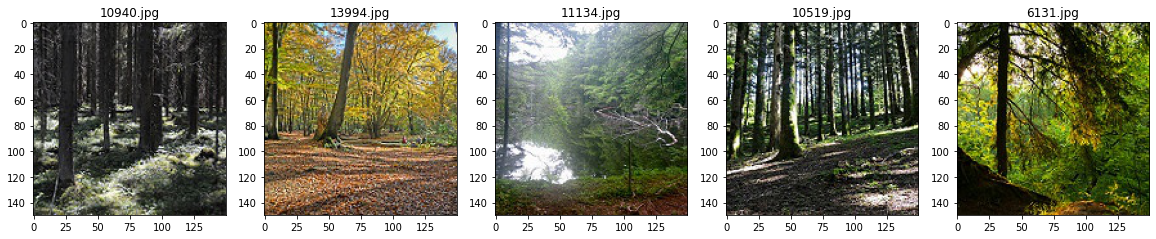

In [4]:
# Image(filename=TRAIN_PATH + "/street/1000.jpg")
plt.figure(figsize=(20,20))
test_folder="../input/intel-image-classification/seg_train/seg_train/forest"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [5]:
# Creating data from the following link
# https://towardsdatascience.com/loading-custom-image-dataset-for-deep-learning-models-part-1-d64fa7aaeca6
def create_dataset(img_folder):
    img_data_array = []
    class_name = []
    for dir1 in os.listdir(img_folder):
        print(dir1)
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255
            img_data_array.append(image)
            class_name.append(dir1)
    img_data_array = np.array(img_data_array, dtype="float32")
    class_name = np.array(class_name)
    return img_data_array, class_name

In [6]:
# extract the image array and class name
img_data, class_name = create_dataset(TRAIN_PATH)

mountain
street
buildings
sea
forest
glacier


In [7]:
# Shuffling the data
img_data, class_name = shuffle(img_data, class_name, random_state=25)

In [8]:
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_val =  [target_dict[class_name[i]] for i in range(len(class_name))]
target_dict

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [9]:
def model(input_shape):
    
    res_conv = ResNet50(include_top=False, weights="imagenet", input_tensor=None, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), pooling=None, classes=1000)
    
    model = Sequential()
    model.add(res_conv)
    
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
            
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
    model.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
    model.add(Conv2D(256, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(256, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.8))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.8))
    model.add(Dense(6))
    
    return model

In [10]:
model = model(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 32)          589856    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0

In [12]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam",)
loss_fn = SparseCategoricalCrossentropy(from_logits=True)

In [13]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
# change optimiser and loss function to see if the model gets better

In [14]:
history = model.fit(x=np.array(img_data, np.float32), y=np.array(list(map(int,target_val)), np.float32), epochs=EPOCHS, batch_size=3)
# history = model.fit(x=tf.cast(np.array(img_data), tf.float64), y=tf.cast(list(map(int,target_val)),tf.int32), epochs=5)

Epoch 1/30
4678/4678 [==============================] - 174s 35ms/step - loss: 1.7242 - accuracy: 0.2179
Epoch 2/30
4678/4678 [==============================] - 164s 35ms/step - loss: 1.3796 - accuracy: 0.3970
Epoch 3/30
4678/4678 [==============================] - 161s 34ms/step - loss: 1.1626 - accuracy: 0.4673
Epoch 4/30
4678/4678 [==============================] - 161s 34ms/step - loss: 1.0340 - accuracy: 0.5595
Epoch 5/30
4678/4678 [==============================] - 161s 34ms/step - loss: 0.9433 - accuracy: 0.6017
Epoch 6/30
4678/4678 [==============================] - 163s 35ms/step - loss: 0.8446 - accuracy: 0.6408
Epoch 7/30
4678/4678 [==============================] - 164s 35ms/step - loss: 0.7893 - accuracy: 0.6657
Epoch 8/30
4678/4678 [==============================] - 163s 35ms/step - loss: 0.7332 - accuracy: 0.6860
Epoch 9/30
4678/4678 [==============================] - 163s 35ms/step - loss: 0.7039 - accuracy: 0.6996
Epoch 10/30
4678/4678 [==============================] 

In [16]:
model.save("IntelCNNepoch30v7Resnet")

In [17]:
# Creating a zip of the model folder
!tar -zcvf IntelCNNepoch30v7Resnet.tar.gz /kaggle/working/IntelCNNepoch30v7Resnet

tar: Removing leading `/' from member names
/kaggle/working/IntelCNNepoch30v7Resnet/
/kaggle/working/IntelCNNepoch30v7Resnet/saved_model.pb
/kaggle/working/IntelCNNepoch30v7Resnet/assets/
/kaggle/working/IntelCNNepoch30v7Resnet/variables/
/kaggle/working/IntelCNNepoch30v7Resnet/variables/variables.data-00000-of-00001
/kaggle/working/IntelCNNepoch30v7Resnet/variables/variables.index


In [18]:
history.history

{'loss': [1.6293829679489136,
  1.3090497255325317,
  1.132730484008789,
  1.0029951333999634,
  0.9164375066757202,
  0.8371788263320923,
  0.7833266854286194,
  0.7234276533126831,
  0.6966682076454163,
  0.6524906158447266,
  0.6293437480926514,
  0.5929523706436157,
  0.5728889107704163,
  0.5312047600746155,
  0.481822669506073,
  0.4443081319332123,
  0.4371630549430847,
  0.3798083961009979,
  0.3791211247444153,
  0.3497171998023987,
  0.339303582906723,
  0.3120661973953247,
  0.2990036904811859,
  0.2831990420818329,
  0.26891204714775085,
  0.2774503231048584,
  0.25666096806526184,
  0.23226074874401093,
  0.22768639028072357,
  0.21699103713035583],
 'accuracy': [0.2834544777870178,
  0.4224027395248413,
  0.4854638874530792,
  0.5699729323387146,
  0.6165740489959717,
  0.6517030000686646,
  0.6737209558486938,
  0.6927461624145508,
  0.7041471004486084,
  0.7213909029960632,
  0.7324355244636536,
  0.7501068711280823,
  0.7732649445533752,
  0.8031209707260132,
  0.83611

In [19]:
loss = history.history["loss"]
acc = history.history["accuracy"]

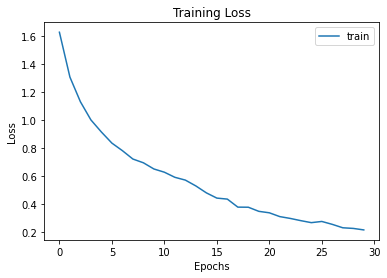

In [20]:
epoch = np.arange(EPOCHS)
plt.plot(epoch, loss)
# plt.plot(epoch, val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(['train', 'val'])

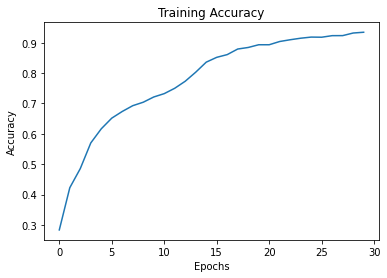

In [21]:
epoch = np.arange(EPOCHS)
plt.plot(epoch, acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy');

In [22]:
pred_img_data, pred_class_name = create_dataset(TEST_PATH)

mountain
street
buildings
sea
forest
glacier


In [23]:
pred_target_dict={k: v for v, k in enumerate(np.unique(pred_class_name))}
pred_target_val =  [pred_target_dict[pred_class_name[i]] for i in range(len(pred_class_name))]
pred_target_dict

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [24]:
test_scores = model.evaluate(np.array(pred_img_data, np.float32), np.array(list(map(int,pred_target_val)), np.float32), verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

94/94 - 4s - loss: 0.9022 - accuracy: 0.8350
Test loss: 0.9021837711334229
Test accuracy: 0.8349999785423279
